# Ricker model
The Ricker model is a well-known ecological model with complex dynamics. It consists of a stochastic latent time series and an observation model. The latent time series can be described as a nonlinear autoregressive model:

$$ \log N^{(t)} = \log r + \log N^{(t-1)} - N^{(t-1)} + \sigma e^{(t)}$$,

where $N^{(t)}$ is the size of an animal population at time $t$ and the $e^{(t)}$ are i.i.d. standard normal error terms. The parameter $r$ acts as a growth rate and $\sigma$ is the standard deviation of the error terms. The observations $y^{(t)}$ are drawn from a Poisson distribution with mean $\varphi N^{(t)}$:

$$ y^{(t)} \sim Poisson(\varphi N^{(t)}) $$.

In total, the model has three parameters $(\log r, \sigma, \varphi)$. The model has been widely used as an example in the ABC literature after it was used by Woods (2011) in his synthetic likelihood approach.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import os
import sys
sys.path.append(os.path.abspath(os.path.join('..')))
import acm2017_pyabc
from acm2017_pyabc.plots import plot_marginals
#from brrr import skrrrahh

%matplotlib notebook

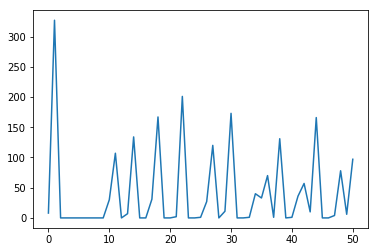

In [2]:
# simulator

def simulator(log_r, sigma, phi, n=50):
    N = [1]
    for t in range(1, n + 1):
        N_t = N[t-1] * np.exp(log_r + -N[t-1] + sigma * np.random.normal())
        N.append(N_t)
        
    N = np.array(N)
    y = np.random.poisson(phi * N)
    return y

np.random.seed(101)

y0 = simulator(3.8, 0.3, 10)
plt.plot(range(51), y0)

## Summary statistics
The statistics used for the Ricker model were: 

(i) The coefficients of the autocovariance function to lag 5.

In [3]:
# autocovariance
def acov(x, k):
    n = np.size(x)
    x_mean = np.mean(x)
    acov = 0
    for i in np.arange(0, n-k):
        acov += ((x[i+k]) - x_mean) * (x[i] - x_mean)
    return (1/(n-1)) * acov

for lag in range(6):
    print(acov(y0, lag))

4793.88313725
-1098.10464437
-764.824190696
-237.863737024
664.202991157
-555.028319877


(ii) The coefficients, β1 and β2 of the autoregression y.3
t+1 = β1y.3 t + β2y.6 t , where the y.3 values were centered by
subtraction of the mean. This autoregression was suggested by exploratory data analysis, and the structure of the Ricker model.

In [4]:
# autoregression
def autoregression(x):
    y_3 = x**3 - np.mean(x**3)
    y_6 = y_3**2

    y = y_3[1:]
    X = np.vstack([y_3[:-1], y_6[:-1]]).T

    beta_hat = np.linalg.lstsq(X,y)[0]
    return beta_hat

autoregression(y0)

array([ -3.09433639e-01,   8.03366551e-09])

(iii) The coefficients of the cubic regression of the ordered first differences of the simulated or actual observed data on the ordered first differences of the actual observed data. These coefficients summarize the shape of the distribution of the differences in the series.

In [5]:
def ofd_regression(x):
    # orderered first differences of observed data
    ofd = np.sort(np.diff(x))
    X = np.vstack([np.ones_like(ofd), ofd, ofd**2, ofd**3]).T
    beta_hat = np.linalg.lstsq(X, ofd)[0]
    return beta_hat

ofd_regression(y0)

array([  8.44506851e-12,   1.00000000e+00,   1.89296019e-16,
         2.10265473e-16])

(iv) The mean of the data and 

In [6]:
np.mean(y0)

40.725490196078432

(v) the number of zeroes observed in the data. There are 14 statistics in all. The statistics were used in transformed form, as described in the methods section, although this makes little difference to the results.

In [7]:
def num_zeros(x):
    return np.count_nonzero(x==0)

num_zeros(y0)

21

In [9]:
summaries = [lambda x: acov(x, 0), lambda x: acov(x, 1), lambda x: acov(x, 2),
             lambda x: acov(x, 3), lambda x: acov(x, 4), lambda x: acov(x, 5), 
             lambda x: autoregression(x),
             lambda x: ofd_regression(x),
             np.mean, num_zeros]

summaries = [lambda x: acov(x, 0), lambda x: acov(x, 1), lambda x: acov(x, 2),
             lambda x: acov(x, 3), lambda x: acov(x, 4), lambda x: acov(x, 5), 
             lambda x: autoregression(x)[0], lambda x: autoregression(x)[0],
             lambda x: ofd_regression(x)[0], lambda x: ofd_regression(x)[1], 
             lambda x: ofd_regression(x)[2], lambda x: ofd_regression(x)[3], 
             np.mean, num_zeros]



In [10]:
[s(y0) for s in summaries]

[4793.8831372549002,
 -1098.1046443675509,
 -764.8241906958865,
 -237.86373702422142,
 664.20299115724731,
 -555.0283198769705,
 -0.3094336392222079,
 -0.3094336392222079,
 8.4450685075823644e-12,
 0.99999999999913936,
 1.8929601931421441e-16,
 2.1026547298139757e-16,
 40.725490196078432,
 21]

# Inference with ABC

In [11]:
# these are kept fixed
sigma = 0.3
phi = 10

# this is inferred
log_r = 3.8

# create observed data
y0 = simulator(log_r, sigma, phi)
y0

array([ 15, 220,   0,   0,   0,   0,   7, 125,   0,   0,  24, 123,   0,
         0,  11, 234,   0,   0,   0,   0,   1,  69,   3,  50,  11,  95,
         0,  11, 154,   0,   0,   3,  72,   9, 208,   0,   0,   0,   1,
        93,   2,   5,  73,   0,  82,   0,  53,  15, 199,   0,   0])

In [12]:
prior_r = acm2017_pyabc.Prior('uniform', 3.2, 1)

## SMC

In [12]:
smc = acm2017_pyabc.SMCSampler(priors = [prior_r], simulator = lambda logr: simulator(logr, sigma, phi), observation = y0, summaries = summaries)


In [19]:
smc.sample(nr_samples=1000, thresholds=[100, 75, 50, 25, 10])
#skrrrahh()

SMC sampler started with thresholds: [100, 75, 50, 25, 10] and number of samples: 1000


KeyboardInterrupt: 

In [ ]:
plot_marginals(smc)

## BOLFI

In [13]:
bolfi = acm2017_pyabc.BOLFI(priors = [prior_r], simulator = lambda logr: simulator(logr, sigma, phi), 
                    observation = y0, summaries = summaries, domain=[(3.2,4.2)])


In [14]:
bolfi.sample(nr_samples=1000, threshold=10, max_iter=200, initial_evidence_size=20)
#skrrrahh()

BOLFI sampler started with threshold: 10 and number of samples: 1000
Starting Bayesian Optimization with initial evidence size = 20, max_iter = 200
Starting MCMC sampling using approximate likelihood with 2 chains and 100 burn-in samples
Samples:   1000 - Threshold: keiner - Iterations:       1002 - Acceptance rate: 0.769461 - Time:   642.58 s


<IPython.core.display.Javascript object>


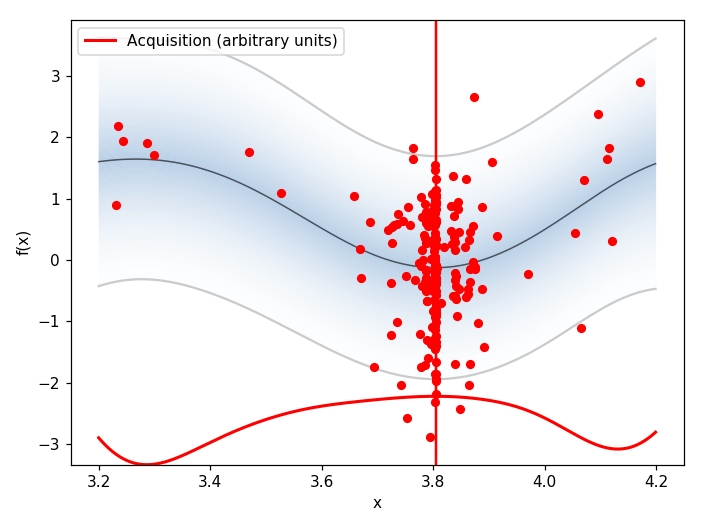

In [14]:
bolfi.optim.plot_acquisition()

<IPython.core.display.Javascript object>


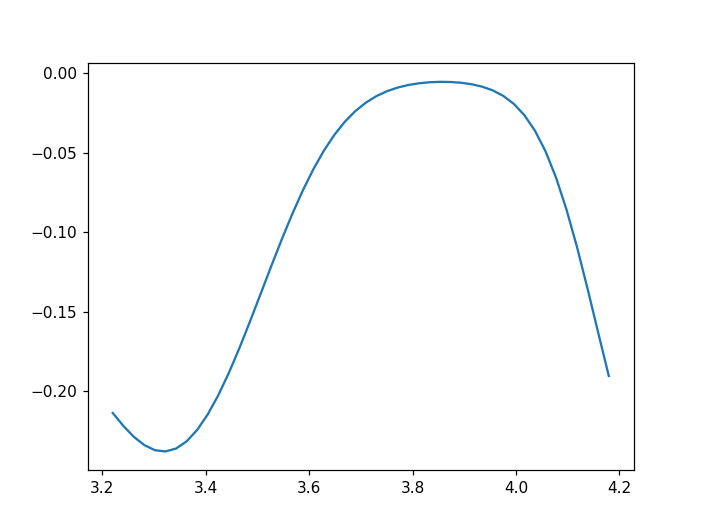

In [15]:
x = np.linspace(3.2, 4.2)
ll = [bolfi.logposterior(np.atleast_1d(x_i)) for x_i in x]

plt.figure()
plt.plot(x, ll)
plt.show()

<IPython.core.display.Javascript object>


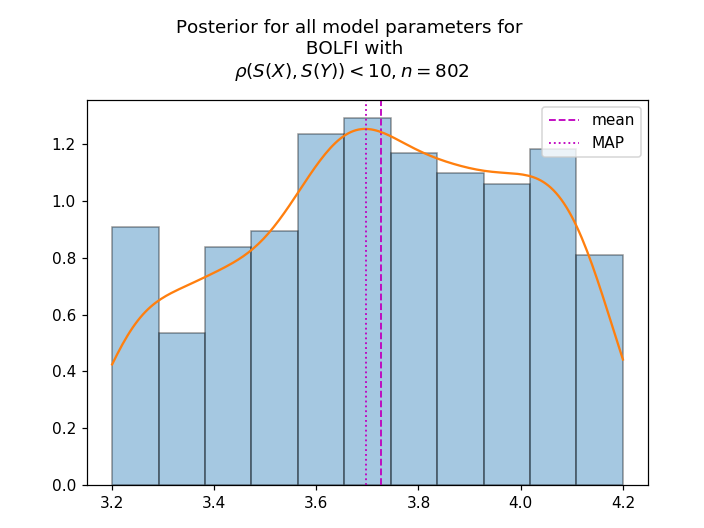

<IPython.core.display.Javascript object>


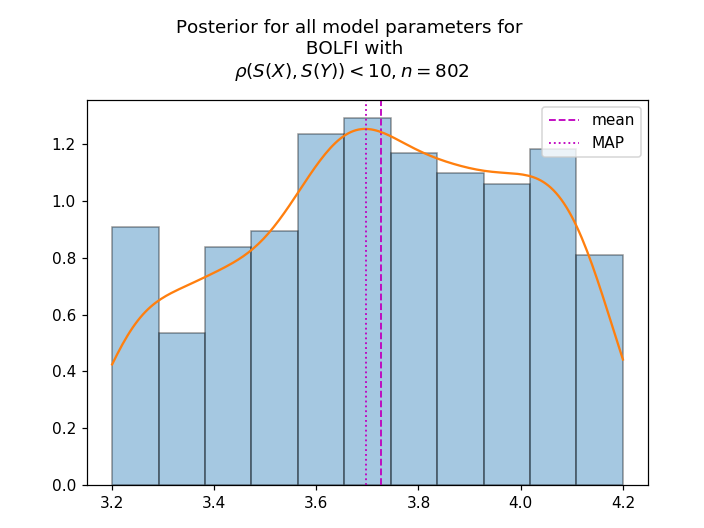

In [16]:
plot_marginals(bolfi)

In [12]:
import elfi

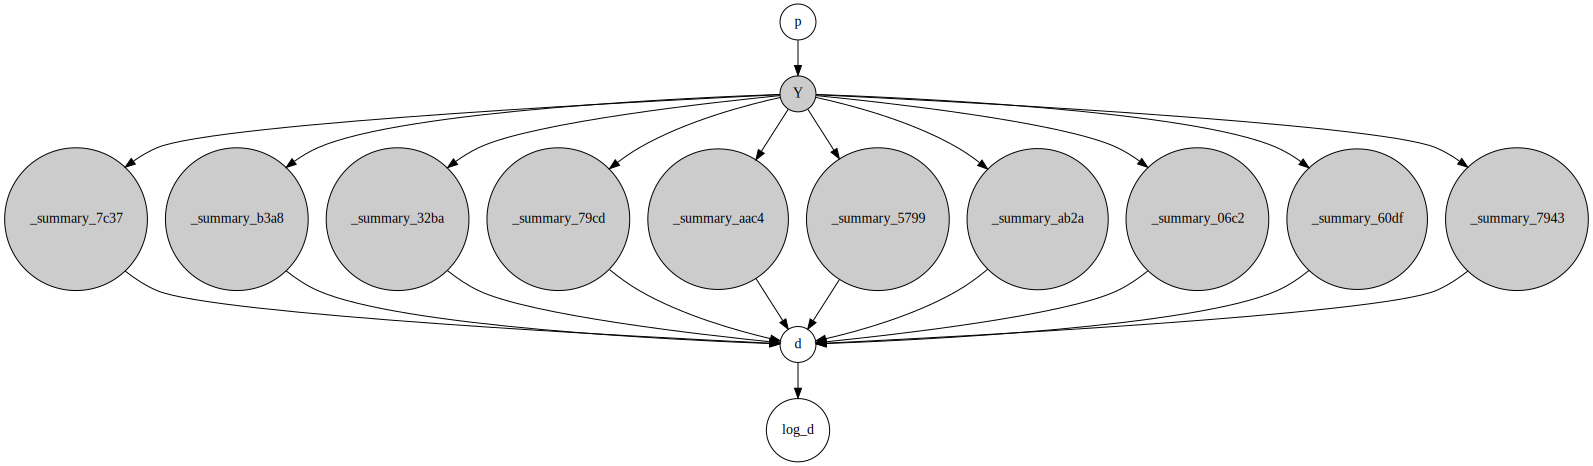

In [13]:
elfi.new_model()

p = elfi.Prior('uniform', 3.2, 4.2)

def sim(log_r, batch_size=1, random_state=np.random):
    return simulator(log_r, sigma, phi)

Y = elfi.Simulator(sim, p, observed=y0)

sums = [elfi.Summary(s, Y) for s in summaries]

d = elfi.Distance('euclidean', *sums)

log_d = elfi.Operation(np.log, d)

elfi.draw(d)

In [14]:
elfibolfi = elfi.BOLFI(log_d, batch_size=1, initial_evidence=20, update_interval=10,
                   bounds={'log_d': (3.2, 4.2)}, acq_noise_var=[0.1], seed=101)

In [15]:
elfibolfi.fit(n_evidence=200)

ValueError: In executing node 'd': all the input array dimensions except for the concatenation axis must match exactly.

<IPython.core.display.Javascript object>


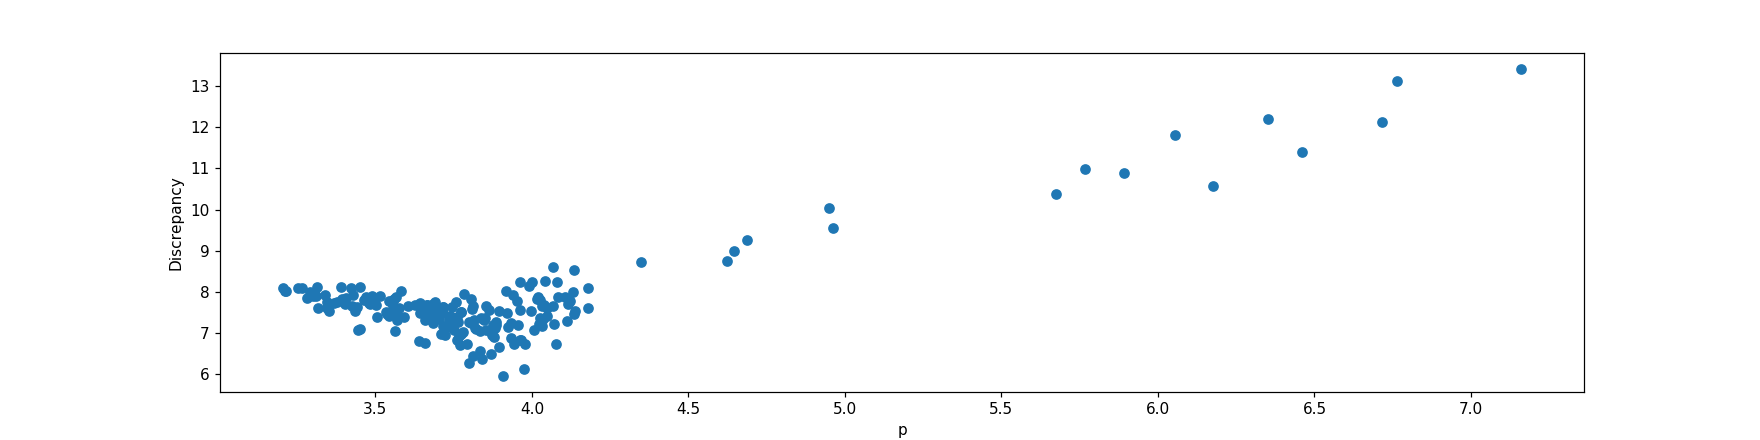

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ffae24cb7b8>], dtype=object)

In [58]:
elfibolfi.plot_discrepancy()

<IPython.core.display.Javascript object>


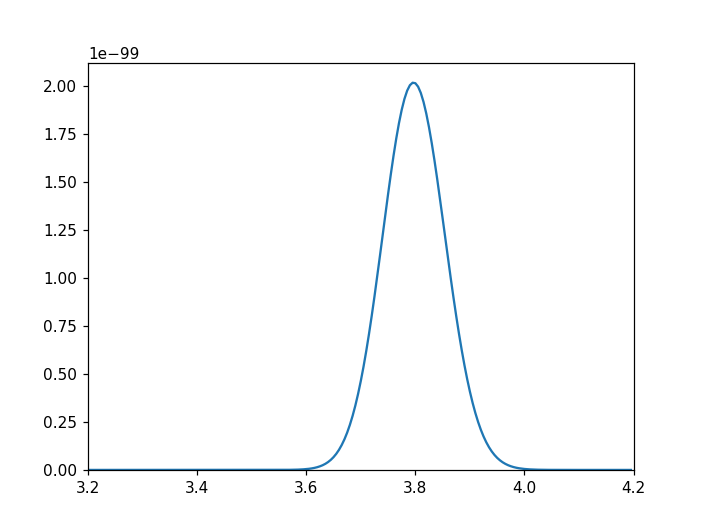

In [55]:
post = elfibolfi.extract_posterior(-1.)
post.plot()

In [52]:
elfibolfi.sample(1000, info_freq=1000)

KeyboardInterrupt: 